## Text analysis and visualization of FCC filings
Clustering documents filed for FCC docket 17-84. Context: loosening regulatory restrictions on access to utility poles for broadband infrastructure e.g. optic fibre, power supply, antennas for small cells etc.   

In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

Create the corpus

In [2]:
corpus_root = './docs/'		#directory path for txt files
newCorpus = PlaintextCorpusReader(corpus_root, '[a-zA-Z0-9_\-]+.txt')

files = newCorpus.fileids()

Extract text from docs.

In [3]:
docs=[] #empty list, append from corpus
row=[] #row index to grab hand coded labels and filer names from external csv file
for f in files:
	docs.append(newCorpus.raw(fileids=f))
	row.append(int(re.sub('(file)|(-[1-9].txt)','',f)))  #document numbers

Vectorize: create term document matrix using unigrams and bigrams

In [4]:
vectorizer = TfidfVectorizer(min_df=0.15, max_df=.5, stop_words='english', ngram_range=(1,2), encoding='utf-8')
X = vectorizer.fit_transform(docs)

Check the dimensions. Note that *document frequencies* have been restricted above

In [5]:
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 377, n_features: 758


So we have 758 features and 377 documents (of nearly 1000 in the FCC's database).

### Initial clustering
Start with a k-means clustering in this 'original' vector space. Will repeat clustering in reduced vector space for comparison later.

In [6]:
km = KMeans(n_clusters=5, init = 'k-means++', n_init=15, max_iter=100)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Reducing the dimension for visualization
Using **singular values** first, and principal components later.

In [7]:
## Dimensionality reduction using SVD (as in Latent Semantic Analysis)
svd = TruncatedSVD(n_components=2).fit(X)
X2D_svd = svd.transform(X)

And the corresponding clustering in this reduced 2 dimensional space.

In [8]:
## Clustering using k-means, separately for each reduced space.  
km_svd = KMeans(n_clusters=5, init = 'k-means++', n_init=15, max_iter=100)
km_svd.fit(X2D_svd)	

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

repeat with principal components. This requires the input matrix to be dense.

In [9]:
Xdense = X.toarray() #PCA does not suppose sparse matrix

In [10]:
pca = PCA(n_components=2).fit(Xdense)  
X2D_pca = pca.transform(Xdense)

clustering...

In [11]:
km_pca = KMeans(n_clusters=5, init = 'k-means++', n_init=15, max_iter=100)
km_pca.fit(X2D_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Visualization

Text(0.5,1,'PCA space (KM-2D)')

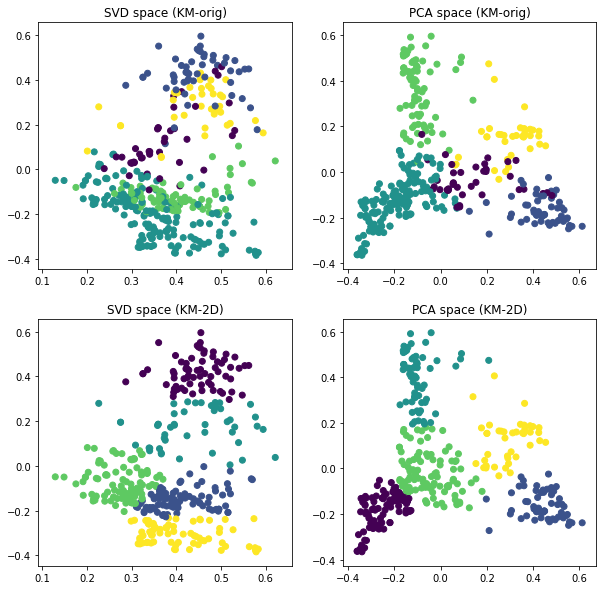

In [15]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10,10))
ax1.scatter(X2D_svd[:,0], X2D_svd[:,1], c = km.labels_)
ax1.set_title('SVD space (KM-orig)')
ax2.scatter(X2D_pca[:,0], X2D_pca[:,1], c = km.labels_)
ax2.set_title('PCA space (KM-orig)')
ax3.scatter(X2D_svd[:,0], X2D_svd[:,1], c = km_svd.labels_)
ax3.set_title('SVD space (KM-2D)')
ax4.scatter(X2D_pca[:,0], X2D_pca[:,1], c = km_pca.labels_)
ax4.set_title('PCA space (KM-2D)')

Both plots on left column are identical (SVD based), and the ones on the right (identical scatter plot)  are based on principal components.

The plots in the top row use coloring based on k-means clustering using the original feature space (758). The bottom row uses clustering in the reduced two-dimensional space. Naturally, there is less "overlap" in clusters when the clustering is done in the reduced vector space (bottom row).